In [1]:
import pandas as pd
import numpy as np
import plotly.figure_factory as ff
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import plotly.colors as pc

# 1. Data Load

We explore the Bike-Share dataset to understand how weather, seasonality, and holidays affect bicycle demand.

This dataset comes with some data processing already applied (e.g., normalization of temperatures, humidity, wind speed...)

In [2]:
# Load the dataset by hour
df = pd.read_csv("../data/hour.csv")
# Read the first entries of the dataset
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### Description of the dataset columns

The `/data/readme.txt` file provides information about the columns present in the dataset.

- **instant**: record index
- **dteday**: date
- **season**: season (1:spring, 2:summer, 3:fall, 4:winter)
- **yr**: year (0: 2011, 1:2012)
- **mnth**: month (1 to 12)
- **hr**: hour (0 to 23)
- **holiday**: weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- **weekday**: day of the week
- **workingday**: if day is neither weekend nor holiday is 1, otherwise is 0.
+ **weathersit**: 
	- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered louds
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- **temp**: Normalized temperature in Celsius. The values are divided to 41 (max)
- **atemp**: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- **hum**: Normalized humidity. The values are divided to 100 (max)
- **windspeed**: Normalized wind speed. The values are divided to 67 (max)
- **casual**: count of casual users
- **registered**: count of registered users
- **cnt**: count of total rental bikes including both casual and registere


# 2. Data Wrangling: Column review and transformation.

Since the dataset contains several columns with normalized values and our objective in this notebook is to perform a descriptive exploration (not to prepare the data for a specific predictive model), we will perform the following steps to facilitate the interpretation of the results:

- Rename columns to make them more understandable.
- Denormalize columns containing scaled values, returning them to their original units.
- Create a temporal index from the date and time.
- Remove columns that are not necessary for exploratory analysis.
- Remove duplicate entries from the temporal index.
- Remove possible outliers within an interquartile range.

These transformations will allow for a clearer interpretation of the data and more informative visualizations.

In [3]:
df = df.rename(columns={
    "temp": "norm_temp",
    "atemp": "norm_atemp",
    "hum": "norm_hum",
    "windspeed": "norm_windspeed"
})

In [4]:
# Denormalize previously normalized columns
df["temp"] = (df["norm_temp"] * 41).round(1) # in Celsius degrees
df["atemp"] = (df["norm_atemp"] * 50).round(1) # in Celsius degrees
df["hum"] = (df["norm_hum"] * 100).round(2) # in percentage
df["windspeed"] = (df["norm_windspeed"] * 67).round(2) # in Km/h

In [5]:
# Convert the 'dteday' column to datetime type
df["timestamp"] = pd.to_datetime(df["dteday"]) + pd.to_timedelta(df["hr"], unit="h")
df["timestamp"] = df["timestamp"].dt.strftime("%Y-%m-%d %H:%M")
df = df.set_index("timestamp")
df.index = pd.to_datetime(df.index)

In [6]:
# Remove unnecessary columns for now
df = df.drop(
    columns=[
        "instant", # No relevant, just an index
        "dteday", # Already converted to timestamp
        "yr", # Already encoded in the timestamp
        "mnth", # Already encoded in the timestamp
        "hr", # Already encoded in the timestamp
        "norm_temp", # Normalized temperature
        "norm_atemp", # Normalized apparent temperature
        "norm_hum", # Normalized humidity
        "norm_windspeed", # Normalized windspeed
    ],
    axis=1,
)

In [7]:
# Reorder the columns
df = df[[
    "season", "holiday", "workingday","weekday","weathersit",
    "temp", "atemp", "hum", "windspeed",
    "casual", "registered", "cnt"
]]

In [8]:
# Show duplicate rows
duplicated = df[df.index.duplicated()]
duplicated
# Remove duplicates from the dataset
df = df[~df.index.duplicated()]
# Sort the DataFrame by index in ascending order
df = df.sort_index(ascending=True)

In [9]:
# Remove outliers outside the interquartile range for the target column of our dataset "cnt"
Q1 = df["cnt"].quantile(0.25)
Q3 = df["cnt"].quantile(0.75)
IQR = Q3 - Q1

# Upper and lower limits
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Keep only data within the allowed range for the target column
df = df[(df["cnt"] >= lower_limit) | (df["cnt"] <= upper_limit)]

## Dataset Description

Once the necessary columns for the analysis have been selected, we will see a description of the values that each one presents.

In [10]:
# Create a summary DataFrame with info and nunique
info = pd.DataFrame({
    "dtype": df.dtypes,
    "nulls": df.isnull().sum(),
    "n_unique": df.nunique()
})
info

,dtype,nulls,n_unique
season,int64,0,4
holiday,int64,0,2
workingday,int64,0,2
weekday,int64,0,7
weathersit,int64,0,4
temp,float64,0,50
atemp,float64,0,65
hum,float64,0,89
windspeed,float64,0,30
casual,int64,0,322


The previous DataFrame provides the following information:

- There are no null or NaN values.
- The data type of each column (int64 or float64) is appropriate for its content.
- The unique values of the `season`, `holiday`, `weekday`, `workingday`, and `weathersit` columns match the information provided in the `Readme.txt` file. These variables appear to be categorical and, probably, one-hot encoding was previously applied to them.

In [11]:
# Statistical summary of the DataFrame
df.describe().round(2)

,season,holiday,workingday,weekday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00
mean,2.50,0.03,0.68,3.00,1.43,20.37,23.79,62.72,12.74,35.68,153.79,189.46
std,1.11,0.17,0.47,2.01,0.64,7.89,8.59,19.29,8.20,49.31,151.36,181.39
min,1.00,0.00,0.00,0.00,1.00,0.80,0.00,0.00,0.00,0.00,0.00,1.00
25%,2.00,0.00,0.00,1.00,1.00,13.90,16.70,48.00,7.00,4.00,34.00,40.00
50%,3.00,0.00,1.00,3.00,1.00,20.50,24.20,63.00,13.00,17.00,115.00,142.00
75%,3.00,0.00,1.00,5.00,2.00,27.10,31.10,78.00,17.00,48.00,220.00,281.00
max,4.00,1.00,1.00,6.00,4.00,41.00,50.00,100.00,57.00,367.00,886.00,977.00


All statistical values shown in the table contain normal values within their range.

# 3. Data Visualization

## 3.1 Distribution of bicycle demand

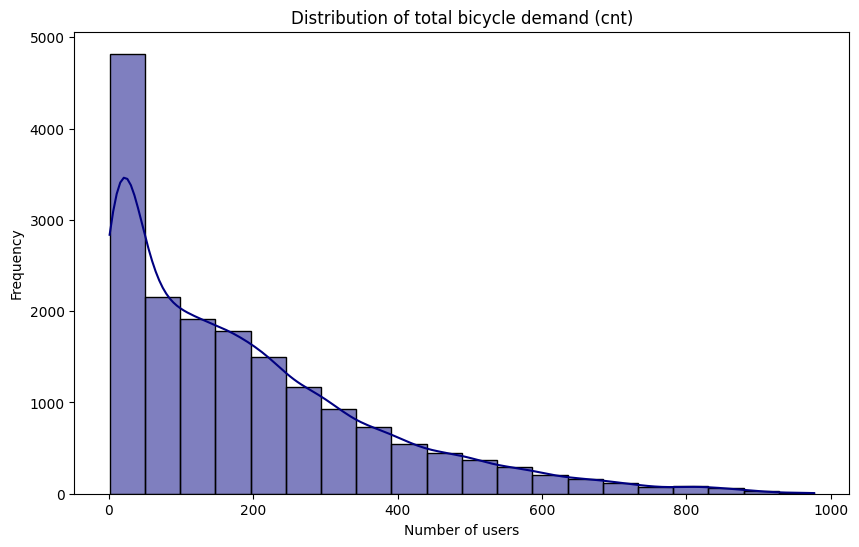

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(df["cnt"], kde=True, bins=20, color="navy")
plt.title("Distribution of total bicycle demand (cnt)")
plt.xlabel("Number of users")
plt.ylabel("Frequency")
plt.show()

## Analysis of Total Bicycle Demand Distribution

The histogram above reveals several important characteristics about bicycle rental demand patterns:

### Distribution Shape and Central Tendency
- **Right-skewed distribution**: The distribution shows a clear positive skew with a long tail extending toward higher values, indicating that while most rental periods have moderate demand, there are occasional periods with exceptionally high usage
- **Peak demand range**: The majority of observations cluster between 50-250 users per hour, with the highest frequency occurring around 100-150 users
- **Modal behavior**: The distribution appears to have multiple peaks, suggesting different usage patterns that likely correspond to various time periods (peak vs off-peak hours, weekdays vs weekends)

### Key Statistical Observations
1. **Low demand periods**: There's a notable frequency of very low demand periods (0-50 users), which likely correspond to:
   - Early morning hours (2-6 AM)
   - Severe weather conditions
   - Holiday periods or off-peak seasons

2. **High demand ceiling**: Very few instances exceed 600 users per hour, indicating either:
   - Natural capacity limitations of the bike-sharing system
   - Practical demand saturation points
   - Effective demand management by the service provider

3. **Variability**: The wide spread (0-800+ users) demonstrates high demand variability, emphasizing the importance of understanding underlying temporal and environmental factors

### Business and Operational Implications

**📊 Resource Planning:**
- The right-skewed nature suggests that while planning for average demand is important, the system must be robust enough to handle occasional high-demand surges
- Infrastructure and bike inventory should account for the 95th percentile demand rather than just the mean

**🚴‍♂️ Fleet Management:**
- The frequent low-demand periods present optimal windows for:
  - Bike maintenance and repairs
  - Redistribution of bikes between stations
  - System updates and station servicing

**🔮 Predictive Modeling Considerations:**
- The multimodal nature suggests that separate models for different contexts (time of day, weather conditions, day type) might be more effective than a single global model
- The presence of extreme values indicates the need for robust modeling approaches that can handle outliers

**💡 Strategic Insights:**
- Understanding the factors that drive the transition from low to high demand periods could inform pricing strategies and promotional campaigns
- The consistent pattern of moderate demand suggests a stable core user base, while extreme values likely represent special events or optimal conditions

## Relationship between weather variables and demand

## Effect of time, day of the week, season and holidays

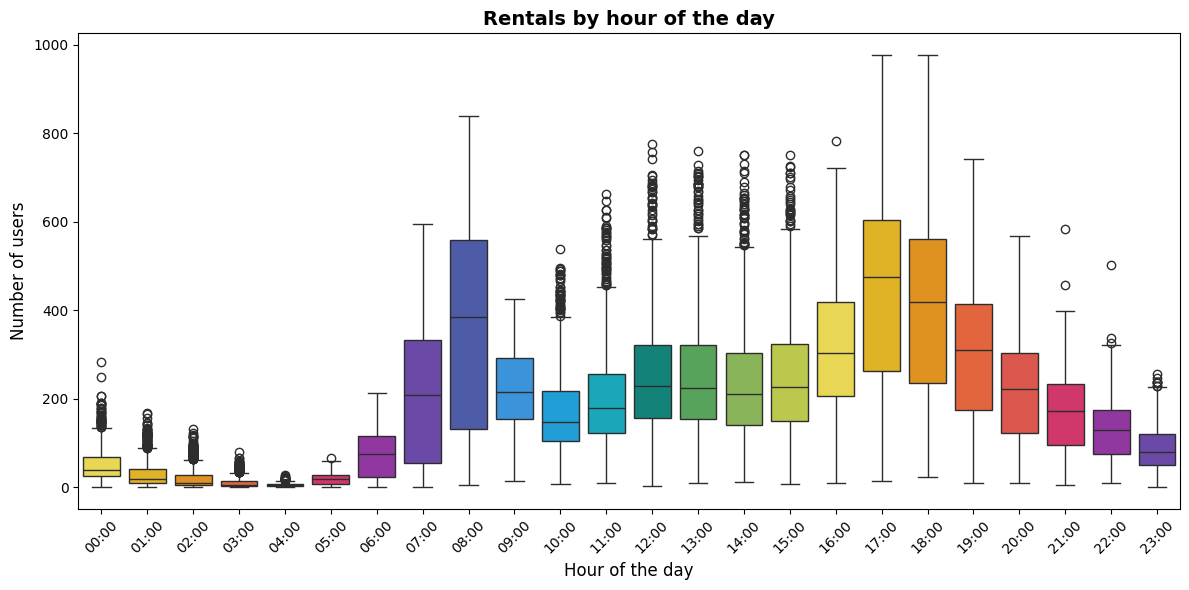

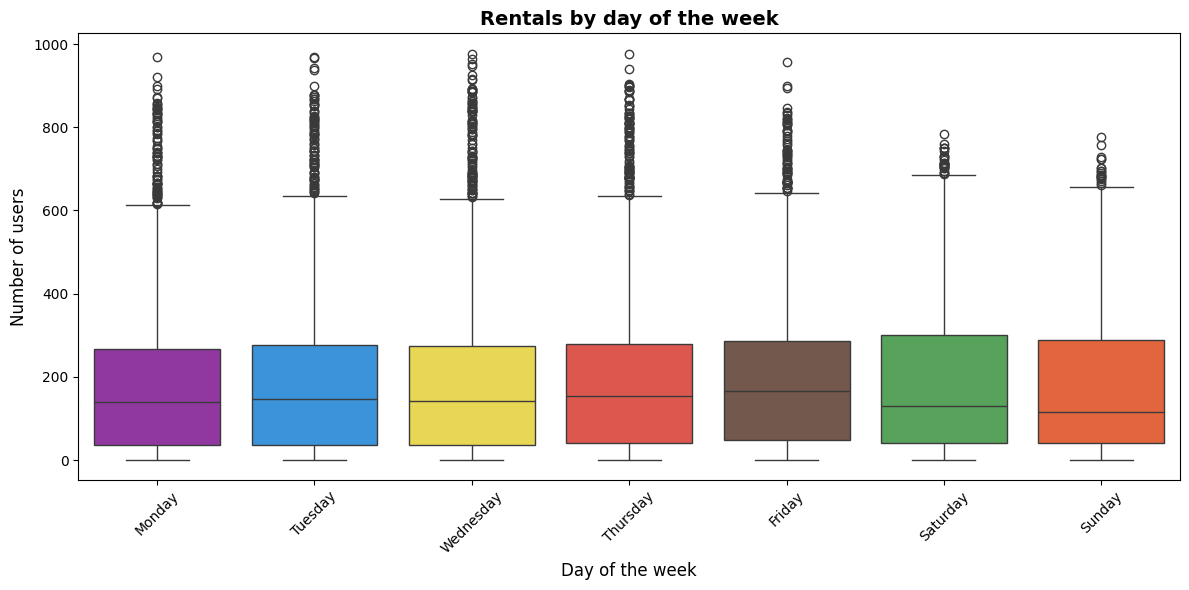

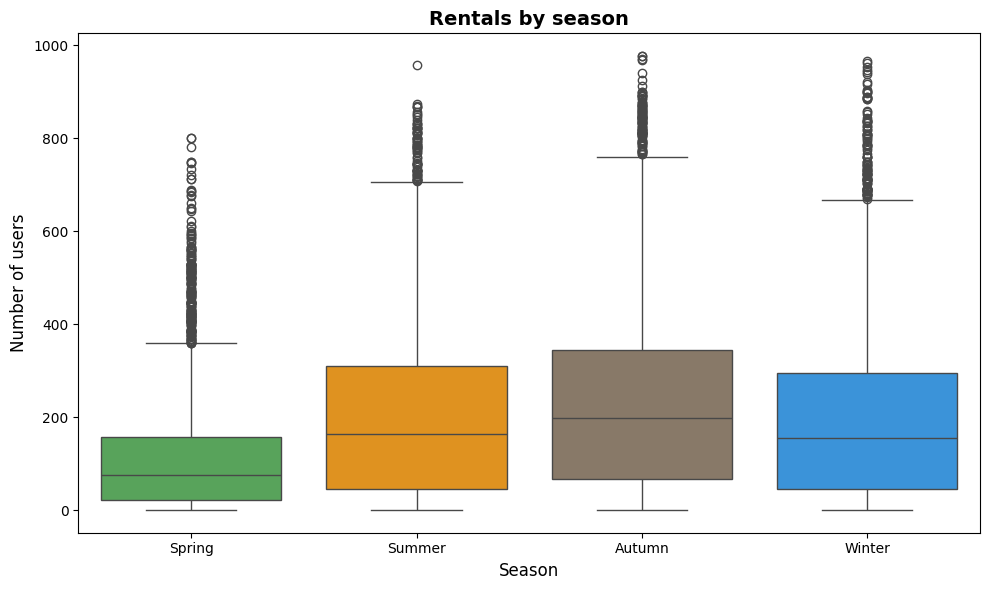

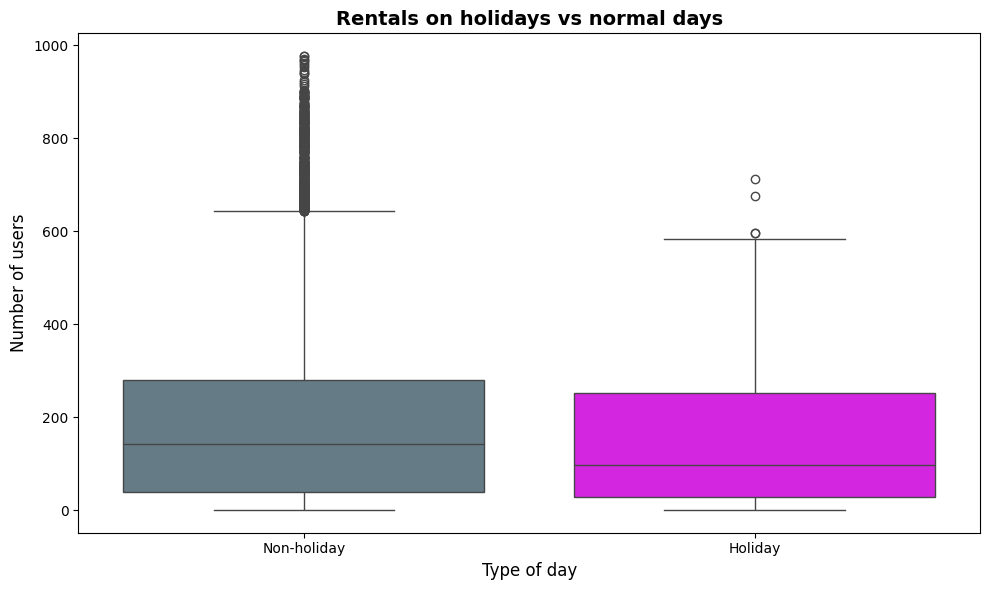

In [16]:
# ----- FIGURE 2: USERS BY HOUR OF THE DAY -----
# Create a dictionary of colors for each hour of the day
hour_colors = {
    0: '#FFEB3B',  # 00:00 - yellow
    1: '#FFC107',  # 01:00 - amber
    2: '#FF9800',  # 02:00 - orange
    3: '#FF5722',  # 03:00 - deep orange
    4: '#F44336',  # 04:00 - red
    5: '#E91E63',  # 05:00 - pink
    6: '#9C27B0',  # 06:00 - purple
    7: '#673AB7',  # 07:00 - deep purple
    8: '#3F51B5',  # 08:00 - indigo
    9: '#2196F3',  # 09:00 - blue
    10: '#03A9F4', # 10:00 - light blue
    11: '#00BCD4', # 11:00 - cyan
    12: '#009688', # 12:00 - teal
    13: '#4CAF50', # 13:00 - green
    14: '#8BC34A', # 14:00 - light green
    15: '#CDDC39', # 15:00 - lime
    16: '#FFEB3B', # 16:00 - yellow (repeated for clarity)
    17: '#FFC107', # 17:00 - amber (repeated for clarity)
    18: '#FF9800', # 18:00 - orange (repeated for clarity)
    19: '#FF5722', # 19:00 - deep orange (repeated for clarity)
    20: '#F44336', # 20:00 - red (repeated for clarity)
    21: '#E91E63', # 21:00 - pink (repeated for clarity)
    22: '#9C27B0', # 22:00 - purple (repeated for clarity)
    23: '#673AB7'   # 23:00 - deep purple (repeated for clarity)
}
# Map hours to names
hour_names = {i: f"{i:02d}:00" for i in range(24)}
# Create a copy of the DataFrame with hours as text
df_hour = df.copy()
df_hour['hour_name'] = df_hour.index.hour.map(hour_names)
# Custom order for hours
hour_order = [f"{i:02d}:00" for i in range(24)]
# Create the graph using seaborn
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_hour, x='hour_name', y='cnt', order=hour_order,
              hue='hour_name', palette=[hour_colors[i] for i in range(24)], legend=False)
plt.title('Rentals by hour of the day', fontsize=14, fontweight='bold')
plt.xlabel('Hour of the day', fontsize=12)
plt.ylabel('Number of users', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ----- FIGURE 3: USERS BY DAY OF THE WEEK -----

# Create distinct colors for each day of the week (more differentiated colors)
day_colors = {
    1: '#4CAF50',  # Monday - green
    2: '#FF5722',  # Tuesday - reddish orange
    3: '#9C27B0',  # Wednesday - purple
    4: '#2196F3',  # Thursday - blue
    5: '#FFEB3B',  # Friday - yellow
    6: '#F44336',  # Saturday - red
    0: '#795548',  # Sunday - brown
}

# Map days of the week to names
day_names = {
    1: 'Monday',
    2: 'Tuesday',
    3: 'Wednesday',
    4: 'Thursday',
    5: 'Friday',
    6: 'Saturday',
    0: 'Sunday',
}

# Create a copy of the DataFrame with days of the week as text
df_temp = df.copy()
df_temp['day_name'] = df_temp['weekday'].map(day_names)

# Custom order for days (Monday to Sunday)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create the graph using seaborn
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_temp, x='day_name', y='cnt', order=day_order, 
           hue='day_name', palette=[day_colors[k] for k in [1, 2, 3, 4, 5, 6, 0]], legend=False)
plt.title('Rentals by day of the week', fontsize=14, fontweight='bold')
plt.xlabel('Day of the week', fontsize=12)
plt.ylabel('Number of users', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ----- FIGURE 4: USERS BY SEASON -----

# Create a dictionary of colors according to the seasons
season_colors = {
    1: '#4CAF50',  # Spring - green
    2: '#FF9800',  # Summer - orange
    3: "#8D7963",  # Autumn - brown
    4: '#2196F3'   # Winter - blue
}

# Map season numbers to names
season_names = {
    1: 'Spring',
    2: 'Summer',
    3: 'Autumn',
    4: 'Winter'
}

# Create a copy of the DataFrame with seasons as text
df_temp_season = df.copy()
df_temp_season['season_name'] = df_temp_season['season'].map(season_names)

# Custom order for seasons
season_order = ['Spring', 'Summer', 'Autumn', 'Winter']

# Create the graph using seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_temp_season, x='season_name', y='cnt', order=season_order,
           hue='season_name', palette=[season_colors[k] for k in [1, 2, 3, 4]], legend=False)
plt.title('Rentals by season', fontsize=14, fontweight='bold')
plt.xlabel('Season', fontsize=12)
plt.ylabel('Number of users', fontsize=12)
plt.tight_layout()
plt.show()

# ----- FIGURE 5: USERS ON HOLIDAYS vs NORMAL DAYS -----

# Colors for holidays and non-holidays
holiday_colors = {
    0: '#607D8B',  # Non-holiday - bluish gray
    1: "#EE07FF6B"   # Holiday - amber yellow
}

# Map holiday to names
holiday_names = {
    0: 'Non-holiday',
    1: 'Holiday'
}

# Create a copy of the DataFrame with holidays as text
df_temp_holiday = df.copy()
df_temp_holiday['holiday_name'] = df_temp_holiday['holiday'].map(holiday_names)

# Create the graph using seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_temp_holiday, x='holiday_name', y='cnt',
           hue='holiday_name', palette=[holiday_colors[0], holiday_colors[1]], legend=False)
plt.title('Rentals on holidays vs normal days', fontsize=14, fontweight='bold')
plt.xlabel('Type of day', fontsize=12)
plt.ylabel('Number of users', fontsize=12)
plt.tight_layout()
plt.show()

## Correlation matrix between variables

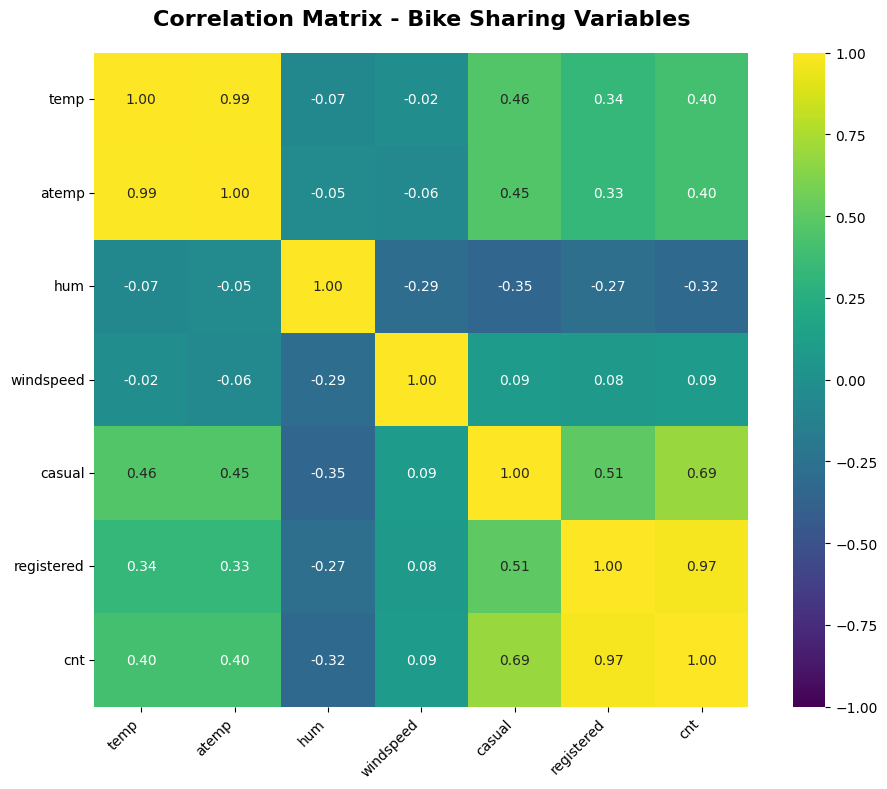

In [22]:
# Create correlation matrix for numerical variables
numerical_vars = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']
corr_matrix = df[numerical_vars].corr()

# Create seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, 
            annot=True,           # Show correlation values
            cmap='viridis',       # Color scheme
            center=0,             # Center colormap at 0
            vmin=-1,              # Minimum value for colorbar
            vmax=1,               # Maximum value for colorbar
            square=True,          # Make cells square
            fmt='.2f',            # Format numbers to 2 decimal places
            cbar_kws={'shrink': 1.0})  # Adjust colorbar size

plt.title('Correlation Matrix - Bike Sharing Variables', fontsize=16, fontweight='bold', pad=20)
plt.xlabel("",fontsize=12)
plt.ylabel("",fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Analysis of Correlation Matrix

The correlation heatmap above reveals important relationships between the variables in our bike-sharing dataset:

### Strong Positive Correlations
- **Temperature variables**: `temp` and `atemp` (apparent temperature) show a very strong correlation (~0.99), which is expected as they measure related thermal conditions
- **User types**: `registered` and `cnt` (total count) show strong correlation (~0.97), indicating that registered users constitute the majority of bike rentals
- **Weather and demand**: Both temperature variables show moderate positive correlations with total bike usage (~0.39-0.63)

### Key Insights
1. **Temperature impact**: Warmer temperatures consistently drive higher bike usage across all user categories
2. **User composition**: Registered users dominate the bike-sharing system, with casual users showing more variable patterns
3. **Weather sensitivity**: 
   - Humidity shows negative correlation with bike usage (higher humidity → lower demand)
   - Wind speed has minimal impact on bike rental patterns
   
### Business Implications
- **Seasonal planning**: Strong temperature correlations suggest clear seasonal demand patterns requiring adaptive fleet management
- **User targeting**: The dominance of registered users indicates the importance of membership retention strategies
- **Weather forecasting**: Temperature and humidity can be reliable predictors for demand forecasting models

## EXTRA

1.  **Deeper Time Series Analysis**:
    *   **Time series decomposition**: Analyze the `cnt` column over time to identify and visualize components such as trend (long-term growth), seasonality (annual, weekly, daily patterns), and residuals (unexplained variability).
    *   **Autocorrelation**: Study the autocorrelation (ACF) and partial autocorrelation (PACF) functions of `cnt` to understand how past values influence future values and detect cyclical patterns.
    *   **Specific hourly patterns**: Although you already analyze the day of the week, you could investigate how the average demand varies for each hour of the day, and how these hourly patterns change between weekdays and weekends, or between different seasons.

2.  **Predictive Modeling of Demand**:
    *   **Model building**: Develop regression models (e.g., Linear Regression, Random Forest, Gradient Boosting, or specific time series models like ARIMA or Prophet) to predict the `cnt` count.
    *   **Feature importance**: Identify which variables (temperature, humidity, day of the week, hour, etc.) are the most important predictors of bicycle demand.
    *   **Performance evaluation**: Measure the accuracy of predictive models to understand how well future demand can be forecasted.

3.  **Segmented Analysis of User Types (Casual vs. Registered)**:
    *   **Differential behavior**: Perform separate exploratory analyses and visualizations for the `casual` and `registered` columns. This could reveal if these two user groups have different sensitivities to weather, day of the week, holidays, or different hourly patterns.
    *   **Proportion of users**: Analyze how the proportion of casual versus registered users changes over time, or under different conditions (e.g., if weekends attract more casual users).
    *   **Separate predictive models**: Consider creating distinct predictive models for casual and registered users, as their usage patterns might be different enough to justify it.

4.  **Analysis of Interaction between Variables**:
    *   **Combined effects**: Investigate how different variables interact. For example, is the effect of temperature on demand different on weekdays compared to weekends? Or how does the weather situation (`sit_meteo`) modulate the impact of the time of day? This can be explored with grouped or faceted visualizations and statistical models that include interaction terms.

These additional analyses can provide a deeper understanding of the factors driving bicycle usage and would allow for the development of more informed strategies for service management.